In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import netCDF4 as nc
import datetime as dt
import cmocean
import string
import glob
from salishsea_tools import viz_tools, places
from salishsea_tools import evaltools as et
import scipy.stats as sst
import matplotlib as mpl
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import FormatStrFormatter
import pickle
import h5py
import NorthNut as nn
fs=8 # fs=8
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = ','.join(r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 '''.split()))
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
%matplotlib inline

NorthNut defined variables: ig0,ig1,jg0,jg1,fformat0
NorthNut defined variables: vmask, vmask0, umask, umask0, tmask, fmask, gdept,  gdept_1d, e1t, e2t, e12t, e1f, e2f, e1v, e2u, e3t_1d
NorthNut defined variables: boxCol, colL, colR, arrowwidth, headwidth, headlength, alen, toff, apw, apk


/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
ig0=nn.ig0
ig1=nn.ig1
jg0=nn.jg0
jg1=nn.jg1
tmaskDIAN=nn.tmask
umaskDIAN=nn.umask
vmaskDIAN=nn.vmask

In [3]:
places.PLACES['Sentry Shoal']

{'EC buoy number': 46131,
 'GEM2.5 grid ji': (183, 107),
 'NEMO grid ji': (707, 145),
 'lon lat': (-125.0, 49.92)}

In [4]:
jss,iss=places.PLACES['Sentry Shoal']['NEMO grid ji']
jssNN,issNN=np.array((jss,iss))-np.array((jg0,ig0))

In [5]:
jss,iss,jssNN,issNN

(707, 145, 63, 33)

In [6]:
sdir='/data/eolson/MEOPAR/SS36runs/linkHC201812/'
saveloc='/data/eolson/MEOPAR/biomodelevalpaper/figsEval/'
fformat0='%Y%m%d'
fformatM='%d%b%y'

In [7]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]

In [8]:
# try 5/14 for  basic fig
iit=dt.datetime(2015,5,14)
fname=iit.strftime(fformatM).lower()+'/SalishSea_1h_*ptrc_T.nc'
fb=nc.Dataset(glob.glob(sdir+fname)[0])

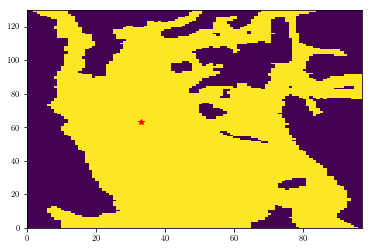

In [9]:
plt.pcolormesh(tmaskDIAN[0,:,:])
plt.plot(issNN,jssNN,'r*')
#plt.plot(50,112,'b*')

In [10]:
ie1=iss
je1=jss
#ie2=50+ig0
#je2=112+jg0
bgcol='olivedrab'
#cm0=cmocean.cm.thermal
cm0=mpl.cm.get_cmap('Oranges')
col1='blueviolet'
col2='green'
colc='black'
colc2='cornflowerblue'

In [11]:
t0=dt.datetime(2015,5,1) # 1st start date of run
te=dt.datetime(2015,9,1)# last start date of run
recalc=False
if recalc==True:
    ilen=(te-t0).days+1
    all1=np.zeros((ilen*24))
    iitime=list()
    iits=t0
    iii=0
    while iits<=te:
        iitime.append(iits)
        with nc.Dataset(glob.glob(sdir+iits.strftime(fformatM).lower()+'/SalishSea_1h_*ptrc_T.nc')[0]) as fi:
            all1[iii*24:(iii+1)*24]=np.mean(fi.variables['nitrate'][:,:2,je1,ie1],1)
        iii=iii+1
        iits=iits+dt.timedelta(days=1)
    iitime=np.array(iitime)
    with open('/data/eolson/MEOPAR/biomodelevalpaper/figsNNut/showPatternVarsSentry.pkl','wb') as ff:
        pickle.dump([iitime,all1],ff)#means1,means2,meansc,meansc2,maxs1,maxs2,maxsc,maxsc2,
else:
    ilen=(te-t0).days+1
    with open('/data/eolson/MEOPAR/biomodelevalpaper/figsNNut/showPatternVarsSentry.pkl','rb') as ff:
        [iitime,all1]=pickle.load(ff) #means1,means2,meansc,meansc2,maxs1,maxs2,maxsc,maxsc2,

In [12]:
it2=[t0+dt.timedelta(hours=hh) for hh in range(0,ilen*24)]
it2=np.array(it2)

In [13]:
saveloc2='/ocean/eolson/MEOPAR/analysis-elise/notebooks/NorthernNitrate/Movie/'
wind=np.load(saveloc2+'saveWindSentryShoal.npz')
windDates=np.array([dt.datetime(2015,1,1)+dt.timedelta(hours=ii) for ii in range(0,24*366)])

In [14]:
len(wind['winddatenum']),len(windDates)

(8784, 8784)

In [15]:
np.shape(e1t)
xx=np.cumsum(e1t[0,:,:],0)/1e3
yy=np.cumsum(e2t[0,:,:],1)/1e3

In [16]:
it0w=np.argmin(np.abs(dt.datetime(2015,5,15)-windDates)) # on
itew=np.argmin(np.abs(dt.datetime(2015,8,21)-windDates)) # off
it0w2=np.argmin(np.abs(dt.datetime(2015,5,1)-windDates)) # on
itew2=np.argmin(np.abs(dt.datetime(2015,9,1)-windDates)) # off

14 May 2015 10:30 UTC


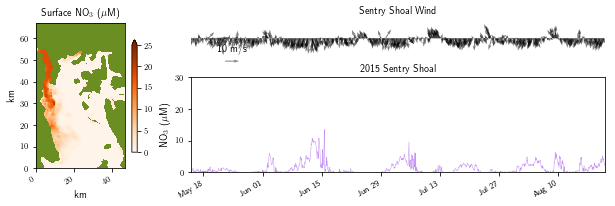

In [17]:
ih=10
iit=dt.datetime(1900,1,1)+dt.timedelta(seconds=fb.variables['time_centered'][:][ih])

fig = plt.figure(figsize=(8.5,2.8))
gs1 = gridspec.GridSpec(2,2,left=.05,right=.98,hspace=0.3,wspace=.2,bottom=0.16,top=.92,width_ratios=[1,4],height_ratios=[1,2.5])
gs0=gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=gs1[:,0],width_ratios=[10,1],wspace=.1)
gsc=gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec=gs0[0,1],height_ratios=[.1,1,.1],wspace=.3)
#gs1=gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec=gs1[1:],height_ratios=[.5,1,.5],wspace=.1)
cbax=fig.add_subplot(gsc[1, 0])
cbax.set_aspect(20/1)
ax0=fig.add_subplot(gs0[0])
ax2=fig.add_subplot(gs1[0,1])
ax1=fig.add_subplot(gs1[1,1])
viz_tools.set_aspect(ax0)
ax0.set_facecolor(bgcol)

iax=ax0 # fig 0: Nitrate
kk=0
clim=(0,25)
mesh0=ax0.contourf(yy[jg0:jg1,ig0:ig1]-yy[jg0,ig0],xx[jg0:jg1,ig0:ig1]-xx[jg0,ig0],
                   np.ma.masked_where(tmask[0,kk,jg0:jg1,ig0:ig1]==0,fb.variables['nitrate'][ih,kk,jg0:jg1,ig0:ig1]),
                   np.linspace(clim[0],clim[1],50),vmin=clim[0],vmax=clim[1],
                         cmap=cm0,extend='max')
cb=fig.colorbar(mesh0,cax=cbax,ticks=np.linspace(clim[0],clim[1],6))
#test=cb.ax.yaxis.get_ticklabels()
#test[0].set_text(u'\u2264{}'.format(test[0].get_text()))
#test[-1].set_text(u'\u2265{}'.format(test[-1].get_text()))
#cb.ax.yaxis.set_ticklabels(test)
ax0.set_title('Surface NO$_3$ ($\mu$M)',fontsize=10)
print(iit.strftime('%d %b %Y %H:%M UTC'))
#ax0.set_xticks([],[]);
#ax0.set_yticks([],[]); 
ax0.plot(jssNN,issNN,'^',color='w')
ax0.plot(jssNN,issNN,'^',color=col1,markeredgecolor='w',markeredgewidth=.5,alpha=.7)
ax0.set_xlabel('km',fontsize=10)
ax0.set_ylabel('km',fontsize=10)
ax0.set_xlim((0,47))
ax0.set_ylim((0,67))
ax1.plot(it2,all1,'-',color=col1,alpha=.5,linewidth=.5)

ax1.plot(iit,fb.variables['nitrate'][ih,kk,je1,ie1],'^',color='w',markersize=2)
#ax1.set_xlim(t0,te)
ax1.set_xlim(dt.datetime(2015,5,15),dt.datetime(2015,8,21))
ax1.set_title('2015 Sentry Shoal ',fontsize=10)
fig.autofmt_xdate(bottom=0.3, rotation=30, ha='right')
yearsFmt = mdates.DateFormatter('%b %d')
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.set_ylabel('NO$_3$ ($\mu$M)',fontsize=10)
ax1.set_ylim(0,30)

q=ax2.quiver(wind['winddatenum'][it0w:itew:3], np.zeros(wind['winddatenum'][it0w:itew:3].shape), 
             wind['us'][it0w:itew:3], wind['vs'][it0w:itew:3],scale=300,alpha=.5)
ax2.set_xlim(wind['winddatenum'][it0w],wind['winddatenum'][itew])
qk = ax2.quiverkey(q, 0.1, -0.1, 10, '10 m/s',fontproperties={'size':10})
ax2.set_title('Sentry Shoal Wind',fontsize=10)
ax2.set_axis_off()
ax1.patch.set_alpha(0)

#ax1.set_position(mpl.transforms.Bbox.from_extents(0.32, 0.2, 0.99, 0.7))
#tmp=ax1.get_position()
#print(tmp)
#fig.savefig('/data/eolson/MEOPAR/biomodelevalpaper/figsNNut/showPatternWind.png',dpi = 400, transparent=False)
#fig.savefig('/data/eolson/MEOPAR/biomodelevalpaper/figsNNut/showPatternWind.eps',dpi = 400, transparent=False)

In [18]:
wind.files

['vs', 'us', 'winddatenum', 'direc', 'wind']

In [19]:
len(wind['vs'])

8784

In [20]:
len(all1),len(wind['wind'][it0w2:itew2])

(2976, 2952)

### wind correlations

comments: stick with wind magnitude; otherwise direction issues complicate things- see first set of correlation plots 

In [21]:
filepath = '/ocean/eolson/MEOPAR/obs/Hakai/SentryShoal/Full_SUNA_Processed.mat'

arrays = {}
f = h5py.File(filepath)
for k, v in f.items():
    arrays[k] = np.array(v)
dates = arrays['Full_SUNA_Processed'][0,:]
times = arrays['Full_SUNA_Processed'][1,:]
temps = arrays['Full_SUNA_Processed'][2,:]
sals = arrays['Full_SUNA_Processed'][3,:]
nitrate = arrays['Full_SUNA_Processed'][5,:]
datenumber = arrays['Full_SUNA_Processed'][-1, :]
base = dt.datetime(2000, 1, 1)
py_times = np.array([base for i in range(63721)])
for n in range(63721):
    py_times[n] = ((dt.datetime.fromordinal(int(datenumber[n])))
                    + dt.timedelta(days=datenumber[n]%1)- dt.timedelta(days = 366))
nitrate2 = np.ma.masked_invalid(nitrate)

In [22]:
bn=np.nan*np.ones(np.shape(it2))
for iii in range(0,len(it2)):
    iix=(py_times>=(it2[iii]-dt.timedelta(hours=.5)))&(py_times<=it2[iii]+dt.timedelta(hours=.5))&(nitrate2>=0)
    if np.sum(iix)>0:
        bn[iii]=np.nanmean(nitrate2[iix])

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


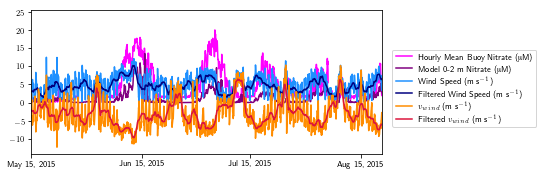

In [23]:
fig,ax=plt.subplots(1,1,figsize=(7.5,2.5))
ax.set_position((.06,.1,.65,.8))
#ax.plot(py_times,nitrate2,'.',color='turquoise',ms=1,label='Buoy Nitrate ($\muup$M)')
ax.plot(it2,bn,'-',color='fuchsia',ms=1,label='Hourly Mean Buoy Nitrate ($\muup$M)')
ax.plot(it2,all1,'-',color='purple',label='Model 0-2 m Nitrate ($\muup$M)')
ax.plot(windDates[it0w2:itew2],wind['wind'][it0w2:itew2],'-',color='dodgerblue',label='Wind Speed (m s$^{-1}$)')#it2,
w2=np.convolve(wind['wind'][it0w2:itew2], np.ones((25,))/25, mode='same') # do not use edges!
ax.plot(windDates[it0w2:itew2],w2,'-',color='navy',label='Filtered Wind Speed (m s$^{-1}$)')

w3=np.convolve(wind['vs'][it0w2:itew2], np.ones((25,))/25, mode='same') # do not use edges!
ax.plot(windDates[it0w2:itew2],wind['vs'][it0w2:itew2],'-',color='darkorange',label='$v_{wind}$ (m s$^{-1}$)')#it2,
ax.plot(windDates[it0w2:itew2],w3,'-',color='crimson',label='Filtered $v_{wind}$ (m s$^{-1}$)')

ax.set_xlim((dt.datetime(2015,5,15),dt.datetime(2015,8,21)))
ax.legend(loc=1,bbox_to_anchor=(1.45,.75))

ax.set_xticks((dt.datetime(2015,5,15),dt.datetime(2015,6,15),dt.datetime(2015,7,15),dt.datetime(2015,8,15)))
yearsFmt = mdates.DateFormatter('%b %d, %Y')
ax.xaxis.set_major_formatter(yearsFmt)

fig.savefig('/data/eolson/MEOPAR/biomodelevalpaper/figsEval/SSNitrateWind.eps',dpi = 400)

(-7, 15)

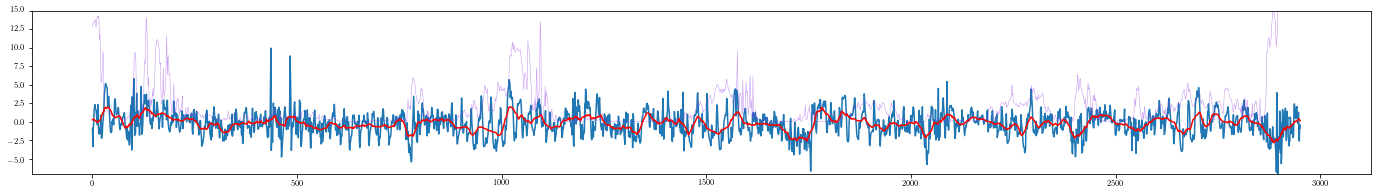

In [24]:
# U Wind
fig,ax=plt.subplots(1,1,figsize=(24,3))
ax.plot(wind['us'][it0w2:itew2])#it2,
w2=np.convolve(wind['us'][it0w2:itew2], np.ones((24,))/24, mode='same') # do not use edges!
ax.plot(all1,'-',color=col1,alpha=.5,linewidth=.5)
ax.plot(w2,'r-')
ax.set_ylim(-7,15)

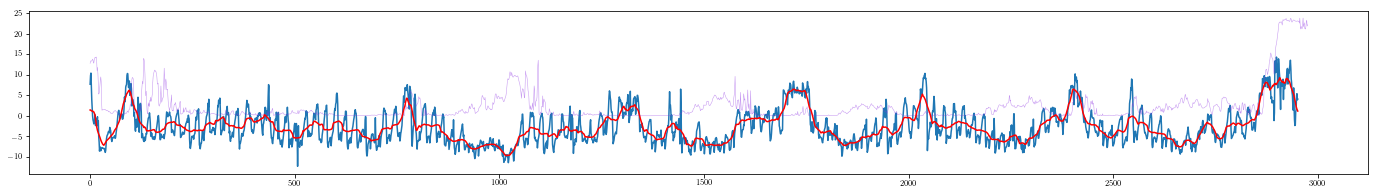

In [25]:
# V Wind
fig,ax=plt.subplots(1,1,figsize=(24,3))
ax.plot(wind['vs'][it0w2:itew2])#it2,
w2=np.convolve(wind['vs'][it0w2:itew2], np.ones((24,))/24, mode='same') # do not use edges!
ax.plot(all1,'-',color=col1,alpha=.5,linewidth=.5)
ax.plot(w2,'r-')

In [26]:
# make wind and N time ranges consistent
windwind=wind['wind'][it0w2:itew2]
windus=wind['us'][it0w2:itew2]
windvs=wind['vs'][it0w2:itew2]

In [27]:
len(windwind),len(all1)

(2952, 2976)

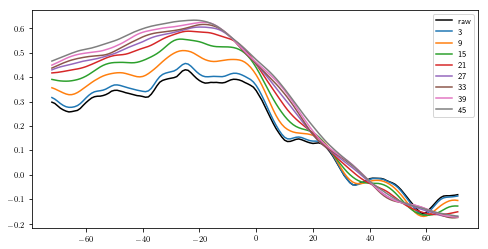

In [28]:
## correlations: wind speed 
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=windwind[(ist+ii):(ien+ii)]
    y=all1[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
for iw in range(3,48,6):
    w2=np.convolve(windwind, np.ones((iw,))/iw, mode='same')
    rsP2=list()
    for ii in range(-72,72):
        x=w2[(ist+ii):(ien+ii)]
        y=all1[ist:ien]
        rsP2.append(sst.pearsonr(x,y)[0])
    ax.plot(iis,rsP2,label=str(iw))
plt.legend()

-20 0.6011823686804643 rsquared: 0.3614202404122537
(0.602572699597675, 1.0431422232752371e-10)
(0.6011823686804643, 3.671370097050583e-231)


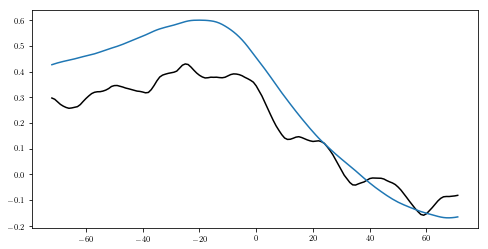

In [29]:
## Wind speed 
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=windwind[(ist+ii):(ien+ii)]
    y=all1[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
w2=np.convolve(windwind, np.ones((25,))/25, mode='same')
rsP2=list()
for ii in range(-72,72):
    x=w2[(ist+ii):(ien+ii)]
    y=all1[ist:ien]
    rsP2.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP2)
iii=np.argmax(rsP2)
print(iis[iii],rsP2[iii],'rsquared:',rsP2[iii]*rsP2[iii])
x=w2[(ist+iis[iii]):(ien+iis[iii])]
y=all1[ist:ien]
print(sst.pearsonr(x[::25],y[::25]))
print(sst.pearsonr(x,y))
# the window length is 25, so it extends for 12 hours before and after the central time which is 21 hours earlier, ie from -33 hours to -9 hours

-41 0.6550545455067597 rsquared: 0.4290964575890675
(0.6550545455067597, 7.344422224216743e-260)
-20 (0.6164508452994778, 6.17555627417409e-222)


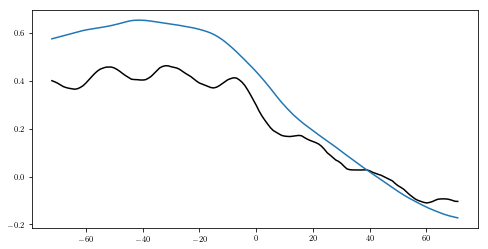

In [30]:
## Wind speed and Sentry Shoal nitrate
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=windwind[(ist+ii):(ien+ii)]
    y=bn[ist:ien]
    iy=~np.isnan(y)
    rsP.append(sst.pearsonr(x[iy],y[iy])[0])
ax.plot(iis,rsP,'k-',label='raw')
w2=np.convolve(windwind, np.ones((25,))/25, mode='same')
rsP2=list()
for ii in range(-72,72):
    x=w2[(ist+ii):(ien+ii)]
    y=bn[ist:ien]
    iy=~np.isnan(y)
    rsP2.append(sst.pearsonr(x[iy],y[iy])[0])
ax.plot(iis,rsP2)
iii=np.argmax(rsP2)
print(iis[iii],rsP2[iii],'rsquared:',rsP2[iii]*rsP2[iii])
x=w2[(ist+iis[iii]):(ien+iis[iii])]
y=bn[ist:ien]
iy=~np.isnan(y)
#print(sst.pearsonr(x[::25],y[::25]))
print(sst.pearsonr(x[iy],y[iy]))

x=w2[(ist-20):(ien-20)]
y=bn[ist:ien]
iy=~np.isnan(y)
print(-20,sst.pearsonr(x[iy],y[iy]))
# the window length is 25, so it extends for 12 hours before and after the central time which is 21 hours earlier, ie from -33 hours to -9 hours

-66 -0.4650817805082413 rsquared: 0.21630106256071593
(-0.4792866131957846, 8.933496050376655e-07)


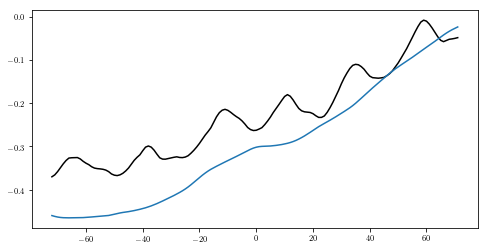

In [31]:
# v wind component 
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=windvs[(ist+ii):(ien+ii)]
    y=all1[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
w2=np.convolve(windvs, np.ones((25,))/25, mode='same')
rsP2=list()
for ii in range(-72,72):
    x=w2[(ist+ii):(ien+ii)]
    y=all1[ist:ien]
    rsP2.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP2)
iii=np.argmax(np.abs(rsP2))
print(iis[iii],rsP2[iii],'rsquared:',rsP2[iii]*rsP2[iii])
x=w2[(ist+iis[iii]):(ien+iis[iii])]
y=all1[ist:ien]
print(sst.pearsonr(x[::25],y[::25]))
# the window length is 25, so it extends for 12 hours before and after the central time which is 21 hours earlier, ie from -33 hours to -9 hours

-22 0.5912258012663866 rsquared: 0.3495479480830808
(0.6065003009762313, 7.320425834509093e-11)


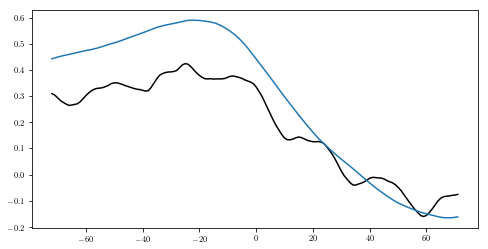

In [32]:
# v wind component abs
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=np.abs(windvs[(ist+ii):(ien+ii)])
    y=all1[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
w2=np.convolve(np.abs(windvs), np.ones((25,))/25, mode='same')
rsP2=list()
for ii in range(-72,72):
    x=w2[(ist+ii):(ien+ii)]
    y=all1[ist:ien]
    rsP2.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP2)
iii=np.argmax(np.abs(rsP2))
print(iis[iii],rsP2[iii],'rsquared:',rsP2[iii]*rsP2[iii])
x=w2[(ist+iis[iii]):(ien+iis[iii])]
y=all1[ist:ien]
print(sst.pearsonr(x[::25],y[::25]))
# the window length is 25, so it extends for 12 hours before and after the central time which is 21 hours earlier, ie from -33 hours to -9 hours

-13 0.4984816891942291 rsquared: 0.248483994461932
(0.5349700496230274, 2.338626611524933e-08)


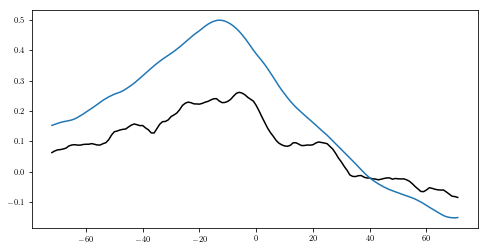

In [33]:
## allc, u wind component abs val only
fig,ax=plt.subplots(1,1,figsize=(8,4))
rsP=list()
iis=list()
ist=np.argmin(np.abs(dt.datetime(2015,5,15)-it2)) # on
ien=np.argmin(np.abs(dt.datetime(2015,8,21)-it2)) # off
for ii in range(-72,72):
    iis.append(ii)
    x=np.abs(windus[(ist+ii):(ien+ii)])
    y=all1[ist:ien]
    rsP.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP,'k-',label='raw')
w2=np.convolve(np.abs(windus), np.ones((25,))/25, mode='same')
rsP2=list()
for ii in range(-72,72):
    x=w2[(ist+ii):(ien+ii)]
    y=all1[ist:ien]
    rsP2.append(sst.pearsonr(x,y)[0])
ax.plot(iis,rsP2)
iii=np.argmax(np.abs(rsP2))
print(iis[iii],rsP2[iii],'rsquared:',rsP2[iii]*rsP2[iii])
x=w2[(ist+iis[iii]):(ien+iis[iii])]
y=all1[ist:ien]
print(sst.pearsonr(x[::25],y[::25]))
# the window length is 25, so it extends for 12 hours before and after the central time which is 21 hours earlier, ie from -33 hours to -9 hours